#### task 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons, load_digits
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        
        # Create encoder layers
        encoder_layers = []
        # First layer from input_size to hidden_size
        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        
        # Middle layers
        for _ in range(layers - 1):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            
        # Final encoder layer to bottleneck
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Create decoder layers (mirror of encoder)
        decoder_layers = []
        # First layer from bottleneck to hidden_size
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())
        
        # Middle layers
        for _ in range(layers - 1):
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            
        # Final decoder layer to output
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction, code

def train_autoencoder(model, train_data, test_data, epochs=100, batch_size=32, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Convert data to tensors
    X_train = torch.FloatTensor(train_data).to(device)
    X_test = torch.FloatTensor(test_data).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        # Shuffle and batch the data
        permutation = torch.randperm(len(X_train))
        total_train_loss = 0
        
        for i in range(0, len(X_train), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x = X_train[indices]
            
            optimizer.zero_grad()
            reconstruction, _ = model(batch_x)
            loss = criterion(reconstruction, batch_x)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item() * len(indices)
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_reconstruction, _ = model(X_test)
            test_loss = criterion(test_reconstruction, X_test).item()
            
        avg_train_loss = total_train_loss / len(X_train)
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses

def plot_reconstruction_comparison(model, data, title="Original vs Reconstructed Data"):
    model.eval()
    with torch.no_grad():
        reconstruction, codes = model(torch.FloatTensor(data))
        
    plt.figure(figsize=(12, 5))
    
    # Original data
    plt.subplot(1, 2, 1)
    plt.scatter(data[:, 0], data[:, 1], c='b', alpha=0.5, label='Original')
    plt.title("Original Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    
    # Reconstructed data
    plt.subplot(1, 2, 2)
    reconstructed_data = reconstruction.numpy()
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c='r', alpha=0.5, label='Reconstructed')
    plt.title("Reconstructed Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    return codes.numpy()

def plot_code_distribution(codes, title="Code Distribution"):
    plt.figure(figsize=(8, 6))
    if codes.shape[1] == 1:
        plt.hist(codes, bins=50, density=True)
        plt.xlabel("Code Value")
        plt.ylabel("Density")
    else:
        plt.scatter(codes[:, 0], codes[:, 1], alpha=0.5)
        plt.xlabel("Code Dimension 1")
        plt.ylabel("Code Dimension 2")
    plt.title(title)
    plt.tight_layout()

def generate_samples_from_gmm(model, gmm, n_samples=1000):
    # Generate samples from the fitted GMM
    synthetic_codes = gmm.sample(n_samples)[0]
    synthetic_codes = torch.FloatTensor(synthetic_codes)
    
    # Generate data using the decoder
    model.eval()
    with torch.no_grad():
        synthetic_data = model.decoder(synthetic_codes)
    
    return synthetic_data.numpy()

Epoch [10/100], Train Loss: 0.0750, Test Loss: 0.0719
Epoch [20/100], Train Loss: 0.0405, Test Loss: 0.0425
Epoch [30/100], Train Loss: 0.0358, Test Loss: 0.0374
Epoch [40/100], Train Loss: 0.0327, Test Loss: 0.0357
Epoch [50/100], Train Loss: 0.0307, Test Loss: 0.0315
Epoch [60/100], Train Loss: 0.0292, Test Loss: 0.0284
Epoch [70/100], Train Loss: 0.0264, Test Loss: 0.0257
Epoch [80/100], Train Loss: 0.0234, Test Loss: 0.0204
Epoch [90/100], Train Loss: 0.0195, Test Loss: 0.0151
Epoch [100/100], Train Loss: 0.0158, Test Loss: 0.0123


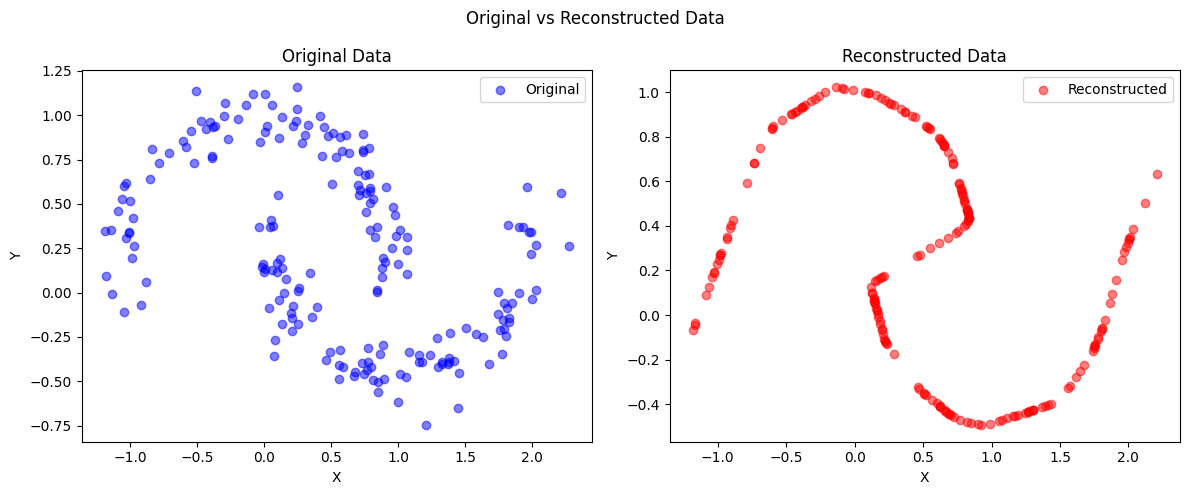

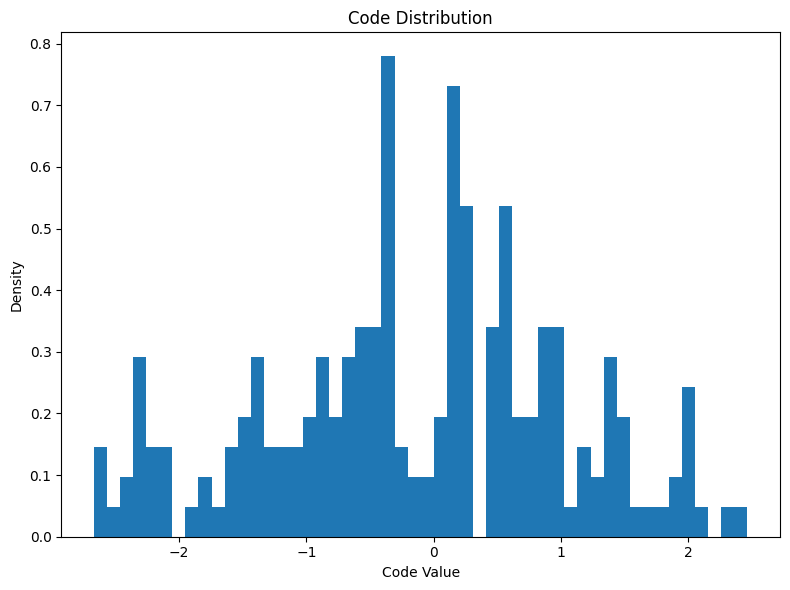

In [2]:
# Generate moon dataset
X, _ = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Create and train autoencoder
model = Autoencoder(
    input_size=2,
    bottleneck_size=1,
    hidden_size=32,
    layers=2
)

train_losses, test_losses = train_autoencoder(
    model,
    X_train,
    X_test,
    epochs=100,
    batch_size=32,
    lr=0.001
)

# Visualize results
codes = plot_reconstruction_comparison(model, X_test)
plot_code_distribution(codes)

# Fit GMM and generate synthetic data
gmm = GaussianMixture(n_components=2)
gmm.fit(codes)
synthetic_data = generate_samples_from_gmm(model, gmm)

In [3]:
import torch
from itertools import product
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def run_hyperparameter_study(
    train_sizes=[1000, 2000, 5000],
    hidden_sizes=[16, 32, 64],
    n_layers=[2, 3, 4],
    epochs=[50, 100, 200],
    learning_rates=[0.0001, 0.001, 0.01],
    noise_level=0.1,
    n_repeats=3
):
    """
    Systematic study of hyperparameter effects on autoencoder performance
    """
    results = []
    
    for train_size, hidden_size, layers, n_epochs, lr in product(
        train_sizes, hidden_sizes, n_layers, epochs, learning_rates
    ):
        for repeat in range(n_repeats):
            # Generate dataset
            X, _ = make_moons(n_samples=train_size + 1000, noise=noise_level, random_state=42 + repeat)
            X_train, X_test = train_test_split(X, test_size=1000, random_state=42 + repeat)
            
            # Create and train model
            model = Autoencoder(
                input_size=2,
                bottleneck_size=1,
                hidden_size=hidden_size,
                layers=layers
            )
            
            train_losses, test_losses = train_autoencoder(
                model,
                X_train,
                X_test,
                epochs=n_epochs,
                batch_size=32,
                lr=lr
            )
            
            # Record results
            results.append({
                'train_size': train_size,
                'hidden_size': hidden_size,
                'layers': layers,
                'epochs': n_epochs,
                'learning_rate': lr,
                'repeat': repeat,
                'final_train_loss': train_losses[-1],
                'final_test_loss': test_losses[-1],
                'model': model,
                'test_data': X_test
            })
    
    return pd.DataFrame(results)

def plot_hyperparameter_effects(results_df):
    """
    Create visualizations of hyperparameter effects
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Effects of Hyperparameters on Test Loss', fontsize=16)
    
    # Plot effect of training size
    sns.boxplot(data=results_df, x='train_size', y='final_test_loss', ax=axes[0,0])
    axes[0,0].set_title('Effect of Training Set Size')
    axes[0,0].set_xlabel('Training Set Size')
    axes[0,0].set_ylabel('Test Loss')
    
    # Plot effect of hidden size
    sns.boxplot(data=results_df, x='hidden_size', y='final_test_loss', ax=axes[0,1])
    axes[0,1].set_title('Effect of Hidden Layer Size')
    axes[0,1].set_xlabel('Hidden Layer Size')
    axes[0,1].set_ylabel('Test Loss')
    
    # Plot effect of number of layers
    sns.boxplot(data=results_df, x='layers', y='final_test_loss', ax=axes[0,2])
    axes[0,2].set_title('Effect of Number of Layers')
    axes[0,2].set_xlabel('Number of Layers')
    axes[0,2].set_ylabel('Test Loss')
    
    # Plot effect of epochs
    sns.boxplot(data=results_df, x='epochs', y='final_test_loss', ax=axes[1,0])
    axes[1,0].set_title('Effect of Training Epochs')
    axes[1,0].set_xlabel('Number of Epochs')
    axes[1,0].set_ylabel('Test Loss')
    
    # Plot effect of learning rate
    sns.boxplot(data=results_df, x='learning_rate', y='final_test_loss', ax=axes[1,1])
    axes[1,1].set_title('Effect of Learning Rate')
    axes[1,1].set_xlabel('Learning Rate')
    axes[1,1].set_ylabel('Test Loss')
    
    # Add text summary of best configuration
    best_config = results_df.loc[results_df['final_test_loss'].idxmin()]
    summary_text = f"Best Configuration:\n" \
                  f"Train Size: {best_config['train_size']}\n" \
                  f"Hidden Size: {best_config['hidden_size']}\n" \
                  f"Layers: {best_config['layers']}\n" \
                  f"Epochs: {best_config['epochs']}\n" \
                  f"Learning Rate: {best_config['learning_rate']}\n" \
                  f"Test Loss: {best_config['final_test_loss']:.6f}"
    axes[1,2].text(0.1, 0.5, summary_text, fontsize=10)
    axes[1,2].axis('off')
    
    plt.tight_layout()
    return best_config

def plot_training_variability(best_params, n_repeats=5, noise_level=0.1):
    """
    Investigate training variability with fixed hyperparameters
    """
    train_losses_list = []
    test_losses_list = []
    reconstructions_list = []
    
    for i in range(n_repeats):
        # Generate new dataset
        X, _ = make_moons(n_samples=int(best_params['train_size']) + 1000, 
                         noise=noise_level, 
                         random_state=42 + i)
        X_train, X_test = train_test_split(X, test_size=1000, random_state=42 + i)
        
        # Create and train model
        model = Autoencoder(
            input_size=2,
            bottleneck_size=1,
            hidden_size=int(best_params['hidden_size']),
            layers=int(best_params['layers'])
        )
        
        train_losses, test_losses = train_autoencoder(
            model,
            X_train,
            X_test,
            epochs=int(best_params['epochs']),
            batch_size=32,
            lr=best_params['learning_rate']
        )
        
        train_losses_list.append(train_losses)
        test_losses_list.append(test_losses)
        
        # Get reconstructions
        with torch.no_grad():
            reconstruction, _ = model(torch.FloatTensor(X_test))
            reconstructions_list.append(reconstruction.numpy())
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for i in range(n_repeats):
        plt.plot(train_losses_list[i], alpha=0.5, label=f'Run {i+1}')
    plt.title('Training Loss Variability')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i in range(n_repeats):
        plt.plot(test_losses_list[i], alpha=0.5, label=f'Run {i+1}')
    plt.title('Test Loss Variability')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    
    return train_losses_list, test_losses_list, reconstructions_list

def test_noise_robustness(model, noise_levels=[0.1, 0.2]):
    """
    Test model performance on different noise levels
    """
    plt.figure(figsize=(12, 4 * len(noise_levels)))
    
    for i, noise in enumerate(noise_levels):
        # Generate test data with current noise level
        X, _ = make_moons(n_samples=1000, noise=noise, random_state=42)
        
        # Get reconstructions
        with torch.no_grad():
            reconstruction, codes = model(torch.FloatTensor(X))
            reconstruction = reconstruction.numpy()
            codes = codes.numpy()
        
        # Plot original vs reconstruction
        plt.subplot(len(noise_levels), 2, 2*i + 1)
        plt.scatter(X[:, 0], X[:, 1], c='b', alpha=0.5, label='Original')
        plt.scatter(reconstruction[:, 0], reconstruction[:, 1], c='r', alpha=0.5, label='Reconstructed')
        plt.title(f'Data Reconstruction (Noise={noise})')
        plt.legend()
        
        # Plot code distribution
        plt.subplot(len(noise_levels), 2, 2*i + 2)
        plt.hist(codes, bins=50, density=True)
        plt.title(f'Code Distribution (Noise={noise})')
        
    plt.tight_layout()

#### task 2

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

class ResidualBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
    
    def forward(self, x):
        return x + self.block(x)

class ResNetAutoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, num_blocks):
        super(ResNetAutoencoder, self).__init__()
        
        # Encoder
        self.encoder_input = nn.Linear(input_size, hidden_size)
        self.encoder_blocks = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size)
            for _ in range(num_blocks)
        ])
        self.encoder_output = nn.Linear(hidden_size, bottleneck_size)
        
        # Decoder
        self.decoder_input = nn.Linear(bottleneck_size, hidden_size)
        self.decoder_blocks = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size)
            for _ in range(num_blocks)
        ])
        self.decoder_output = nn.Linear(hidden_size, input_size)
        
    def encode(self, x):
        h = self.encoder_input(x)
        for block in self.encoder_blocks:
            h = block(h)
        return self.encoder_output(h)
    
    def decode(self, z):
        h = self.decoder_input(z)
        for block in self.decoder_blocks:
            h = block(h)
        return self.decoder_output(h)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

def compute_mmd(x, y, bandwidths):
    """
    Compute Maximum Mean Discrepancy between x and y using multiple bandwidths
    """
    def gaussian_kernel(x, y, bandwidth):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        
        x = x.unsqueeze(1)  # (x_size, 1, dim)
        y = y.unsqueeze(0)  # (1, y_size, dim)
        
        kernel_input = (x - y).pow(2).sum(2) / (2 * bandwidth * bandwidth)
        return torch.exp(-kernel_input)
    
    def compute_kernel_mean(x, y, bandwidth):
        x_size = x.size(0)
        y_size = y.size(0)
        
        kernel_xx = gaussian_kernel(x, x, bandwidth).sum() / (x_size * x_size)
        kernel_xy = gaussian_kernel(x, y, bandwidth).sum() / (x_size * y_size)
        kernel_yy = gaussian_kernel(y, y, bandwidth).sum() / (y_size * y_size)
        
        return kernel_xx + kernel_yy - 2 * kernel_xy
    
    total_mmd = 0
    for bandwidth in bandwidths:
        total_mmd += compute_kernel_mean(x, y, bandwidth)
    
    return total_mmd / len(bandwidths)

def train_mmd_autoencoder(
    model, 
    train_data, 
    test_data, 
    epochs=100,
    batch_size=32,
    lr=0.001,
    bandwidths=[0.1, 0.2, 0.4, 0.8, 1.6],
    mmd_weight=0.1
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Convert data to tensors
    X_train = torch.FloatTensor(train_data).to(device)
    X_test = torch.FloatTensor(test_data).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    reconstruction_criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    mmd_losses = []
    
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(len(X_train))
        total_train_loss = 0
        total_mmd_loss = 0
        
        for i in range(0, len(X_train), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x = X_train[indices]
            
            # Generate standard normal samples for MMD
            z_normal = torch.randn(len(indices), model.encoder_output.out_features).to(device)
            
            optimizer.zero_grad()
            reconstruction, codes = model(batch_x)
            
            # Compute reconstruction loss
            recon_loss = reconstruction_criterion(reconstruction, batch_x)
            
            # Compute MMD loss
            mmd_loss = compute_mmd(codes, z_normal, bandwidths)
            
            # Total loss
            loss = recon_loss + mmd_weight * mmd_loss
            
            loss.backward()
            optimizer.step()
            
            total_train_loss += recon_loss.item() * len(indices)
            total_mmd_loss += mmd_loss.item() * len(indices)
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_reconstruction, test_codes = model(X_test)
            test_loss = reconstruction_criterion(test_reconstruction, X_test).item()
            
        avg_train_loss = total_train_loss / len(X_train)
        avg_mmd_loss = total_mmd_loss / len(X_train)
        
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)
        mmd_losses.append(avg_mmd_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'MMD Loss: {avg_mmd_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses, mmd_losses

def generate_samples(model, n_samples=1000):
    """
    Generate synthetic samples by sampling from standard normal and decoding
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.encoder_output.out_features).to(device)
        samples = model.decode(z)
    return samples.cpu().numpy()

def visualize_mmd_results(model, original_data, train_losses, test_losses, mmd_losses):
    """
    Comprehensive visualization of MMD autoencoder results
    """
    fig = plt.figure(figsize=(15, 10))
    
    # Plot training curves
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 3, 2)
    plt.plot(mmd_losses)
    plt.title('MMD Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plot original vs reconstructed data
    with torch.no_grad():
        reconstruction, codes = model(torch.FloatTensor(original_data))
        reconstruction = reconstruction.numpy()
        codes = codes.numpy()
    
    plt.subplot(2, 3, 3)
    plt.scatter(original_data[:, 0], original_data[:, 1], c='b', alpha=0.5, label='Original')
    plt.scatter(reconstruction[:, 0], reconstruction[:, 1], c='r', alpha=0.5, label='Reconstructed')
    plt.title('Data Reconstruction')
    plt.legend()
    
    # Plot code distribution
    plt.subplot(2, 3, 4)
    plt.scatter(codes[:, 0], codes[:, 1], alpha=0.5)
    plt.title('Code Distribution')
    plt.xlabel('Code Dimension 1')
    plt.ylabel('Code Dimension 2')
    
    # Plot generated samples
    synthetic_data = generate_samples(model)
    plt.subplot(2, 3, 5)
    plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], c='g', alpha=0.5)
    plt.title('Generated Samples')
    
    plt.tight_layout()
    return codes, synthetic_data

Epoch [10/200], Train Loss: 0.0001, MMD Loss: 0.0363, Test Loss: 0.0001
Epoch [20/200], Train Loss: 0.0001, MMD Loss: 0.0352, Test Loss: 0.0000
Epoch [30/200], Train Loss: 0.0001, MMD Loss: 0.0314, Test Loss: 0.0002
Epoch [40/200], Train Loss: 0.0001, MMD Loss: 0.0291, Test Loss: 0.0004
Epoch [50/200], Train Loss: 0.0001, MMD Loss: 0.0304, Test Loss: 0.0002
Epoch [60/200], Train Loss: 0.0002, MMD Loss: 0.0296, Test Loss: 0.0002
Epoch [70/200], Train Loss: 0.0002, MMD Loss: 0.0288, Test Loss: 0.0004
Epoch [80/200], Train Loss: 0.0002, MMD Loss: 0.0272, Test Loss: 0.0003
Epoch [90/200], Train Loss: 0.0001, MMD Loss: 0.0268, Test Loss: 0.0002
Epoch [100/200], Train Loss: 0.0001, MMD Loss: 0.0254, Test Loss: 0.0001
Epoch [110/200], Train Loss: 0.0002, MMD Loss: 0.0275, Test Loss: 0.0000
Epoch [120/200], Train Loss: 0.0002, MMD Loss: 0.0281, Test Loss: 0.0002
Epoch [130/200], Train Loss: 0.0001, MMD Loss: 0.0284, Test Loss: 0.0001
Epoch [140/200], Train Loss: 0.0002, MMD Loss: 0.0266, Test 

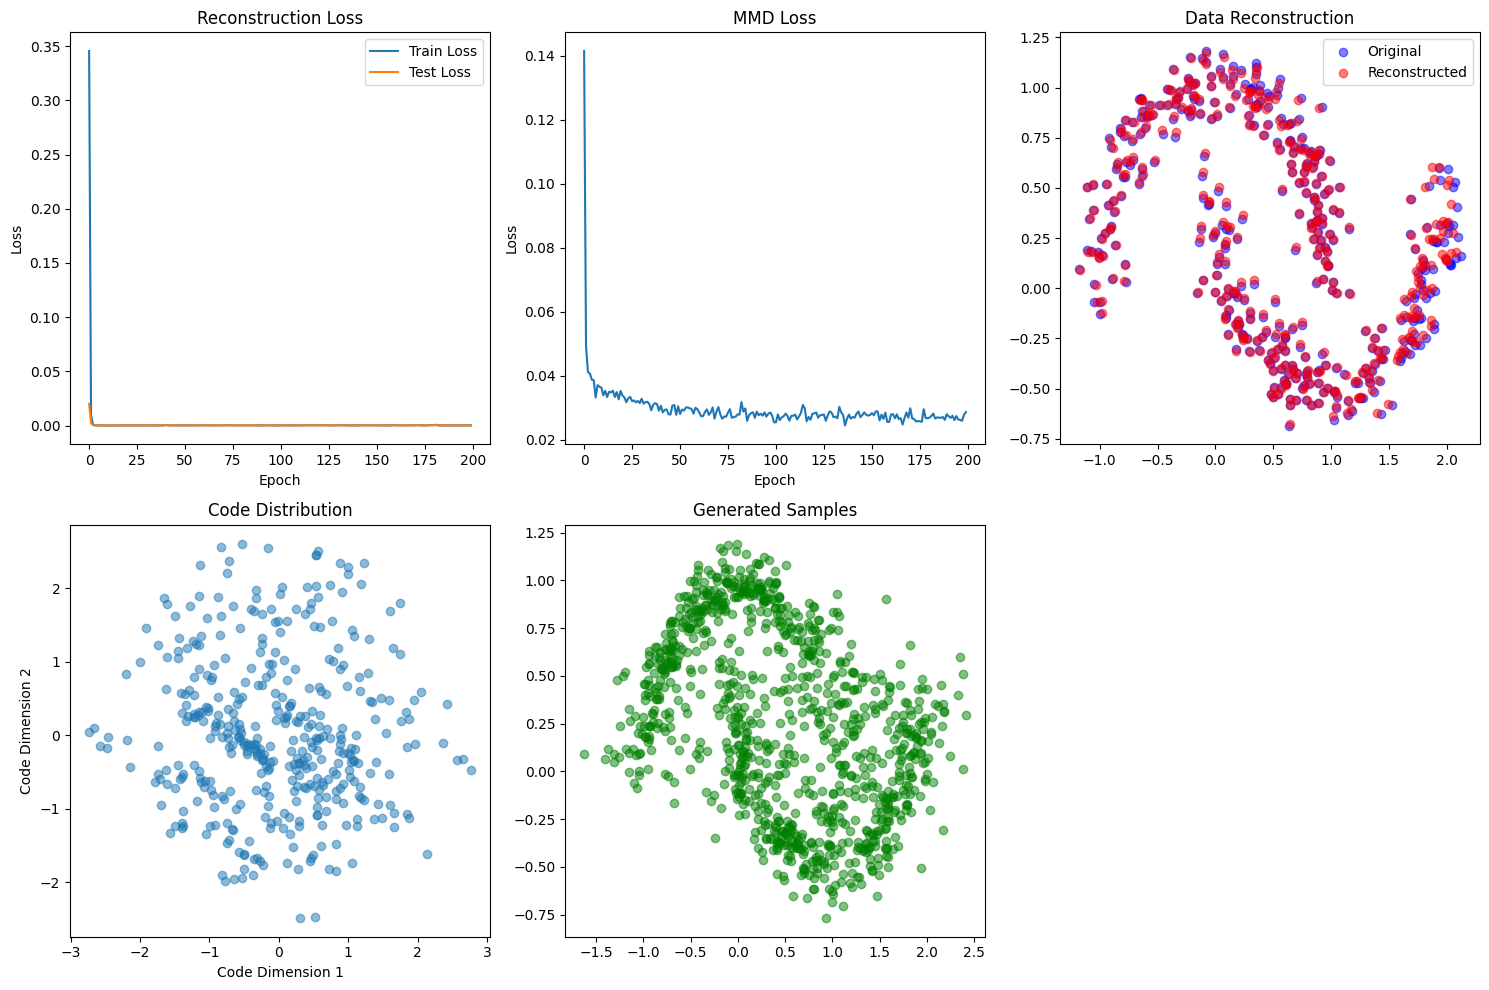

In [5]:
# Generate moon dataset
X, _ = make_moons(n_samples=2000, noise=0.1, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Create and train MMD autoencoder
model = ResNetAutoencoder(
    input_size=2,
    bottleneck_size=2,
    hidden_size=64,
    num_blocks=3
)

train_losses, test_losses, mmd_losses = train_mmd_autoencoder(
    model,
    X_train,
    X_test,
    epochs=200,
    batch_size=64,
    lr=0.001,
    bandwidths=[0.1, 0.2, 0.4, 0.8, 1.6],
    mmd_weight=0.1
)

# Visualize results
codes, synthetic_data = visualize_mmd_results(model, X_test, train_losses, test_losses, mmd_losses)

#### task 3

In [6]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_digits_data():
    """
    Load and preprocess the digits dataset
    """
    # Load digits dataset
    digits = load_digits()
    X = digits.data
    y = digits.target
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler

def analyze_digits_autoencoder(bottleneck_sizes=[2, 4, 8]):
    """
    Comprehensive analysis of autoencoder performance on digits dataset
    """
    # Prepare data
    X_train, X_test, y_train, y_test, scaler = prepare_digits_data()
    input_size = X_train.shape[1]  # 64 for digits dataset
    
    results = {}
    for bottleneck_size in bottleneck_sizes:
        print(f"\nAnalyzing bottleneck size: {bottleneck_size}")
        
        # Create and train autoencoder
        model = Autoencoder(
            input_size=input_size,
            bottleneck_size=bottleneck_size,
            hidden_size=128,
            layers=3
        )
        
        train_losses, test_losses = train_autoencoder(
            model,
            X_train,
            X_test,
            epochs=100,
            batch_size=32,
            lr=0.001
        )
        
        # Get reconstructions and codes
        model.eval()
        with torch.no_grad():
            train_recon, train_codes = model(torch.FloatTensor(X_train))
            test_recon, test_codes = model(torch.FloatTensor(X_test))
            
            train_recon = train_recon.numpy()
            test_recon = test_recon.numpy()
            train_codes = train_codes.numpy()
            test_codes = test_codes.numpy()
        
        # Train classifier on original data
        clf_original = RandomForestClassifier(n_estimators=100, random_state=42)
        clf_original.fit(X_train, y_train)
        original_pred = clf_original.predict(X_test)
        
        # Train classifier on reconstructed data
        clf_recon = RandomForestClassifier(n_estimators=100, random_state=42)
        clf_recon.fit(train_recon, y_train)
        recon_pred = clf_recon.predict(test_recon)
        
        # Store results
        results[bottleneck_size] = {
            'model': model,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_codes': train_codes,
            'test_codes': test_codes,
            'train_recon': train_recon,
            'test_recon': test_recon,
            'original_predictions': original_pred,
            'recon_predictions': recon_pred,
            'true_labels': y_test
        }
        
        # Print classification reports
        print("\nOriginal Data Classification Report:")
        print(classification_report(y_test, original_pred))
        print("\nReconstructed Data Classification Report:")
        print(classification_report(y_test, recon_pred))
    
    return results

def visualize_digits_results(results, original_images):
    """
    Comprehensive visualization of digits autoencoder results
    """
    n_bottlenecks = len(results)
    
    # Plot reconstruction examples for each bottleneck size
    plt.figure(figsize=(15, 3 * n_bottlenecks))
    
    for i, (bottleneck_size, result) in enumerate(results.items()):
        # Select random test examples
        indices = np.random.choice(len(original_images), 5)
        
        for j, idx in enumerate(indices):
            # Original
            plt.subplot(n_bottlenecks, 10, i*10 + j + 1)
            plt.imshow(original_images[idx].reshape(8, 8), cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f'Bottleneck={bottleneck_size}\nOriginal')
            
            # Reconstruction
            plt.subplot(n_bottlenecks, 10, i*10 + j + 6)
            plt.imshow(result['test_recon'][idx].reshape(8, 8), cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title('Reconstructed')
    
    plt.tight_layout()
    
    # Plot learning curves
    plt.figure(figsize=(15, 5))
    for bottleneck_size, result in results.items():
        plt.plot(result['test_losses'], label=f'Bottleneck={bottleneck_size}')
    plt.title('Test Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # For bottleneck size 2, visualize the latent space
    if 2 in results:
        plt.figure(figsize=(10, 8))
        codes = results[2]['test_codes']
        labels = results[2]['true_labels']
        
        plt.scatter(codes[:, 0], codes[:, 1], c=labels, cmap='tab10')
        plt.colorbar()
        plt.title('2D Latent Space Visualization')
        plt.xlabel('First Latent Dimension')
        plt.ylabel('Second Latent Dimension')
    
    plt.tight_layout()

def analyze_synthetic_digits(results, bottleneck_size=2):
    """
    Generate and analyze synthetic digits using GMM
    """
    result = results[bottleneck_size]
    codes = result['train_codes']
    
    # Fit GMM to the latent codes
    n_components = 10  # One per digit
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(codes)
    
    # Generate synthetic samples
    n_samples = 50
    synthetic_codes = gmm.sample(n_samples)[0]
    
    # Decode the synthetic samples
    model = result['model']
    with torch.no_grad():
        synthetic_digits = model.decoder(torch.FloatTensor(synthetic_codes))
        synthetic_digits = synthetic_digits.numpy()
    
    # Visualize synthetic digits
    plt.figure(figsize=(15, 5))
    for i in range(min(25, n_samples)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Synthetic Digits (Bottleneck Size={bottleneck_size})')
    plt.tight_layout()
    
    # Classify synthetic digits
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(result['train_recon'], result['true_labels'])
    synthetic_labels = clf.predict(synthetic_digits)
    
    # Plot distribution of predicted labels
    plt.figure(figsize=(8, 4))
    plt.hist(synthetic_labels, bins=range(11), align='left')
    plt.title('Distribution of Predicted Labels for Synthetic Digits')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.xticks(range(10))
    
    return synthetic_digits, synthetic_labels


Analyzing bottleneck size: 2
Epoch [10/100], Train Loss: 0.5033, Test Loss: 0.4504
Epoch [20/100], Train Loss: 0.4540, Test Loss: 0.4075
Epoch [30/100], Train Loss: 0.3998, Test Loss: 0.3942
Epoch [40/100], Train Loss: 0.3751, Test Loss: 0.3878
Epoch [50/100], Train Loss: 0.3910, Test Loss: 0.4155
Epoch [60/100], Train Loss: 0.3226, Test Loss: 0.3747
Epoch [70/100], Train Loss: 0.3362, Test Loss: 0.3743
Epoch [80/100], Train Loss: 0.2983, Test Loss: 0.3739
Epoch [90/100], Train Loss: 0.2919, Test Loss: 0.3729
Epoch [100/100], Train Loss: 0.2791, Test Loss: 0.3681

Original Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       1.00      0.94      0.97        34
           4       0.98      1.00      0.99        46
           5       0.94      0.96      0.95        47
           6

IndexError: index 1255 is out of bounds for axis 0 with size 360

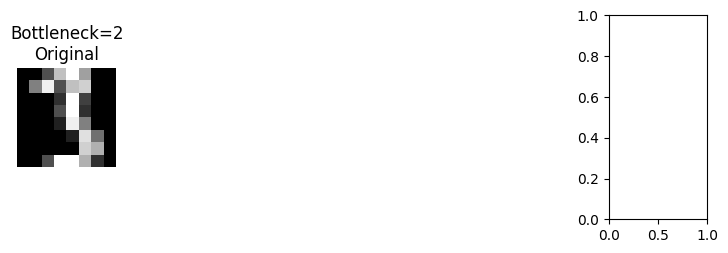

In [7]:
# Run comprehensive analysis
results = analyze_digits_autoencoder(bottleneck_sizes=[2, 4, 8])

# Load original digit images for visualization
digits = load_digits()
X = digits.data

# Visualize results
visualize_digits_results(results, X)

# Generate and analyze synthetic digits
synthetic_digits, synthetic_labels = analyze_synthetic_digits(results, bottleneck_size=2)